### Monte Carlo

In [ ]:
import gymnasium as gym  # Importing gym library, make sure to use the correct import statement for gym
import numpy as np
import math
import time
from collections import defaultdict

env = gym.make("CartPole-v1")  # Create the CartPole environment

# Define parameters for discretizing the state space
theta_minmax = env.observation_space.high[2]
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50

# Function to discretize the continuous state space into discrete states
def discretised_state(state):
    discrete_state = np.array([0,0])     # Initialize discrete state array
    theta_window =  (theta_minmax - (-theta_minmax)) / theta_state_size
    try:
        discrete_state[0] = (state[0][2] - (-theta_minmax)) // theta_window
        discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

        theta_dot_window = (theta_dot_minmax - (-theta_dot_minmax)) / theta_dot_state_size
        discrete_state[1] = (state[0][3] - (-theta_dot_minmax)) // theta_dot_window
        discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))
    except:
        discrete_state[0] = (state[2] - (-theta_minmax)) // theta_window
        discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

        theta_dot_window = (theta_dot_minmax - (-theta_dot_minmax)) / theta_dot_state_size
        discrete_state[1] = (state[3] - (-theta_dot_minmax)) // theta_dot_window
        discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))

    return tuple(discrete_state.astype(int))

# Monte Carlo Agent class for training and playing CartPole
class MonteCarloAgent:
    def __init__(self, env, gamma=1.0):
        self.env = env
        self.gamma = gamma
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Function to generate an episode using the current policy
    def generate_episode(self):
        episode = []
        state = self.env.reset()
        done = False
        sum_rewards = 0
        while not done:
            action = self.env.action_space.sample()  # Random action
            next_state, reward, done, _, _ = self.env.step(action)
            state = discretised_state(state)
            episode.append((state, action, reward))
            sum_rewards += reward
            state = next_state
        return episode, sum_rewards

    # Function to update the Q-values using Monte Carlo method
    def update_Q(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.returns_sum[(state, actions[i])] += sum(rewards[i:] * discounts[:-(1+i)])
            self.returns_count[(state, actions[i])] += 1.0
            self.Q[state][actions[i]] = self.returns_sum[(state, actions[i])] / self.returns_count[(state, actions[i])]

    # Function to get the policy action for a given state
    def get_policy(self, state):
        return np.argmax(self.Q[state])

    # Function to train the agent for a given number of episodes
    def train(self, num_episodes=1000):
        rewards = []
        for i in range(num_episodes):
            episode, reward = self.generate_episode()
            self.update_Q(episode)
            rewards.append(reward)
            if ((i+1)%100)==0:
                print("Trained ", i+1, "episode ")
                if self.play() >= 195:
                    break

    # Function to play CartPole using the learned policy
    def play(self, num_episodes=100, flag=False):
        sum_rewards = 0
        for _ in range(num_episodes):
            if flag:
                self.env = gym.make('CartPole-v1', render_mode="human")
                self.env.observation_space.high[0] = 2.4
                self.env.observation_space.low[0] = -2.4
            state = self.env.reset()
            done = False
            rewards = 0
            while not done:
                state = discretised_state(state)
                action = self.get_policy(state)
                state, reward, done, _, _ = self.env.step(action)
                rewards += reward
                self.env.render()
                if rewards >= 475:
                    done = True
                if flag:
                    time.sleep(0.000002)
            sum_rewards += rewards
        self.env.close()
        if flag:
            self.env = gym.make('CartPole-v1')
            self.env.observation_space.high[0] = 2.4
            self.env.observation_space.low[0] = -2.4
        print("avg reward for the last", num_episodes, "episodes is", sum_rewards / num_episodes)
        return (sum_rewards / num_episodes)

# Usage example:
env = gym.make('CartPole-v1')
env.observation_space.high[0] = 2.4
env.observation_space.low[0] = -2.4
agent = MonteCarloAgent(env)
agent.train(num_episodes=500)
agent.play(num_episodes=1, flag=True)


Trained  100 episode 


D:\Miniconda\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


avg reward for the last 100 episodes is 34.42
Trained  200 episode 
avg reward for the last 100 episodes is 72.66
Trained  300 episode 
avg reward for the last 100 episodes is 358.71
avg reward for the last 1 episodes is 475.0


475.0

### Q learning

[2.4000001e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-2.4000001e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2
Episode:0 avg:28.0 min:28.0 max:28.0
Episode:100 avg:21.34 min:9.0 max:60.0


D:\Miniconda\lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Episode:200 avg:20.42 min:8.0 max:56.0
Episode:300 avg:21.96 min:9.0 max:54.0
Episode:400 avg:31.1 min:10.0 max:92.0
Episode:500 avg:30.61 min:9.0 max:97.0
Episode:600 avg:41.8 min:11.0 max:151.0
Episode:700 avg:54.01 min:11.0 max:280.0
Episode:800 avg:69.61 min:10.0 max:396.0
Episode:900 avg:97.83 min:9.0 max:446.0
Episode:1000 avg:103.84 min:13.0 max:475.0
Episode:1100 avg:189.14 min:11.0 max:475.0
Episode:1200 avg:202.73 min:14.0 max:475.0


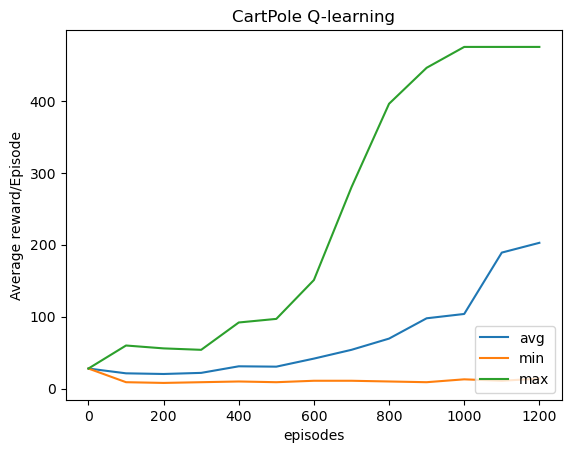

In [ ]:
import gym
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print environment observation space and action space
env.observation_space.high[0] = 2.4
env.observation_space.low[0] = -2.4
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

# Hyperparameters
episodes = 5000
gamma = 0.95
episode_display = 100
alpha = 0.7
eps = 0.2

# Define Q-Table size based on state space and action space
theta_minmax = env.observation_space.high[2]
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50
Q_TABLE = np.random.randn(theta_state_size, theta_dot_state_size, env.action_space.n)

# Lists to store episode rewards and statistics
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

# Function to discretize state space
def discretised_state(state):
    discrete_state = np.array([0, 0])  # Initialised discrete array
    theta_window = (theta_minmax - (-theta_minmax)) / theta_state_size
    try:
        discrete_state[0] = (state[0][2] - (-theta_minmax)) // theta_window
        discrete_state[0] = min(theta_state_size - 1, max(0, discrete_state[0]))

        theta_dot_window = (theta_dot_minmax - (-theta_dot_minmax)) / theta_dot_state_size
        discrete_state[1] = (state[0][3] - (-theta_dot_minmax)) // theta_dot_window
        discrete_state[1] = min(theta_dot_state_size - 1, max(0, discrete_state[1]))
    except:
        discrete_state[0] = (state[2] - (-theta_minmax)) // theta_window
        discrete_state[0] = min(theta_state_size - 1, max(0, discrete_state[0]))

        theta_dot_window = (theta_dot_minmax - (-theta_dot_minmax)) / theta_dot_state_size
        discrete_state[1] = (state[3] - (-theta_dot_minmax)) // theta_dot_window
        discrete_state[1] = min(theta_dot_state_size - 1, max(0, discrete_state[1]))

    return tuple(discrete_state.astype(int))

# Loop over episodes
for episode in range(episodes):
    episode_reward = 0
    done = False

    # Determine if episode should render environment
    if episode % episode_display == 0:
        render_state = True
    else:
        render_state = False

    # Reset the environment and get initial state
    curr_discrete_state = discretised_state(env.reset())
    if np.random.random() > eps:
        action = np.argmax(Q_TABLE[curr_discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)

    # Loop within an episode until termination
    while not done:
        new_state, reward, done, _, _, = env.step(action)
        new_discrete_state = discretised_state(new_state)

        # Choose action using epsilon-greedy policy
        if np.random.random() > eps:
            new_action = np.argmax(Q_TABLE[new_discrete_state])
        else:
            new_action = np.random.randint(0, env.action_space.n)

        # Render the environment if specified
        if render_state:
            env.render()

        # Update Q-table
        if not done:
            current_q = Q_TABLE[curr_discrete_state + (action,)]
            max_future_q = np.max(Q_TABLE[new_discrete_state])
            new_q = current_q + alpha * (reward + gamma * max_future_q - current_q)
            Q_TABLE[curr_discrete_state + (action,)] = new_q

        # Update current state and action
        curr_discrete_state = new_discrete_state
        action = new_action

        episode_reward += reward
        if episode_reward == 475:
            done = True

    # Store episode reward
    ep_rewards.append(episode_reward)

    # Update statistics every episode_display (100) episodes
    if not episode % episode_display:
        avg_reward = sum(ep_rewards[-episode_display:]) / len(ep_rewards[-episode_display:])
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-episode_display:]))
        ep_rewards_table['max'].append(max(ep_rewards[-episode_display:]))
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-episode_display:])} max:{max(ep_rewards[-episode_display:])}")

        if avg_reward >= 195:
            break

# Close the environment
env.close()

# Plot episode rewards statistics
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4)  # bottom right
plt.title('CartPole Q-learning')
plt.ylabel('Average reward/Episode')
plt.xlabel('episodes')
plt.show()


In [ ]:
env = gym.make("CartPole-v1", render_mode='human')
env.reset()
done = False
# Loop within an episode until termination
while not done:
    new_state, reward, done, _, _, = env.step(action)
    new_discrete_state = discretised_state(new_state)

    new_action = np.argmax(Q_TABLE[new_discrete_state])

    # Render the environment if specified
    env.render()
    time.sleep(0.000002)

    # Update current state and action
    curr_discrete_state = new_discrete_state
    action = new_action

    episode_reward += reward

print(episode_reward)

2582.0


### Sarsa

[2.4000001e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-2.4000001e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2
Episode:0 avg:13.0 min:13.0 max:13.0
Episode:100 avg:28.66 min:8.0 max:140.0
Episode:200 avg:27.02 min:8.0 max:83.0
Episode:300 avg:22.75 min:8.0 max:76.0
Episode:400 avg:29.39 min:8.0 max:113.0
Episode:500 avg:30.04 min:9.0 max:168.0
Episode:600 avg:37.04 min:9.0 max:137.0
Episode:700 avg:43.63 min:8.0 max:207.0
Episode:800 avg:56.93 min:9.0 max:239.0
Episode:900 avg:71.18 min:9.0 max:449.0
Episode:1000 avg:65.57 min:9.0 max:309.0
Episode:1100 avg:120.68 min:10.0 max:466.0
Episode:1200 avg:111.77 min:9.0 max:475.0
Episode:1300 avg:134.54 min:10.0 max:475.0
Episode:1400 avg:154.79 min:9.0 max:475.0
Episode:1500 avg:156.3 min:12.0 max:475.0
Episode:1600 avg:160.04 min:15.0 max:475.0
Episode:1700 avg:181.99 min:12.0 max:475.0
Episode:1800 avg:192.35 min:12.0 max:475.0
Episode:1900 avg:189.87 min:9.0 max:475.0
Episode:2000 avg:183.45 min:16.0 max:475.0
Episode:2100 avg

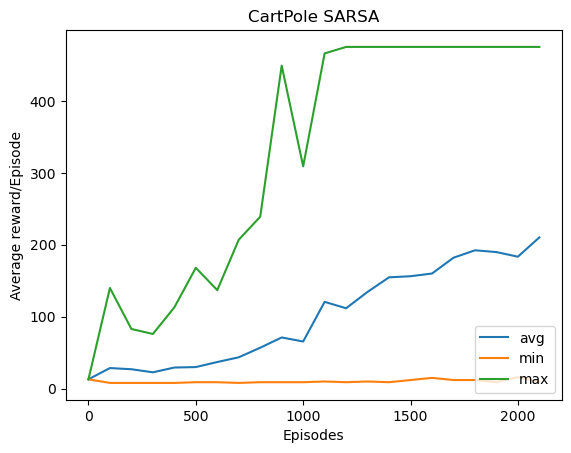

In [ ]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import time

env = gym.make("CartPole-v1")

#Environment values
env.observation_space.high[0] = 2.4
env.observation_space.low[0] = -2.4
print(env.observation_space.high)	#[2.4 3.4028235e+38 4.1887903e-01 3.4028235e+38]
print(env.observation_space.low)	#[-2.4 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
print(env.action_space.n)			#2

#Hyperparamters
EPISODES = 8000
DISCOUNT = 0.95
EPISODE_DISPLAY = 100
LEARNING_RATE = 0.5
EPSILON = 0.2

#Q-Table of size theta_state_size*theta_dot_state_size*env.action_space.n
theta_minmax = env.observation_space.high[2]
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50
Q_TABLE = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)

# For stats
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

def discretised_state(state):
	#state[2] -> theta
	#state[3] -> theta_dot
	discrete_state = np.array([0,0])		#Initialised discrete array
	theta_window =  ( theta_minmax - (-theta_minmax) ) / theta_state_size
	try:
		discrete_state[0] = ( state[0][2] - (-theta_minmax) ) // theta_window
		discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

		theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ theta_dot_state_size
		discrete_state[1] = ( state[0][3] - (-theta_dot_minmax) ) // theta_dot_window
		discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))
	except:
		discrete_state[0] = ( state[2] - (-theta_minmax) ) // theta_window
		discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

		theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ theta_dot_state_size
		discrete_state[1] = ( state[3] - (-theta_dot_minmax) ) // theta_dot_window
		discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))

	return tuple(discrete_state.astype(int))

for episode in range(EPISODES):
	episode_reward = 0
	done = False

	if episode % EPISODE_DISPLAY == 0:
		render_state = True
	else:
		render_state = True

	curr_discrete_state = discretised_state(env.reset())
	if np.random.random() > EPSILON:
		action = np.argmax(Q_TABLE[curr_discrete_state])
	else:
		action = np.random.randint(0, env.action_space.n)

	while not done:
		new_state, reward, done, _,_ = env.step(action)
		new_discrete_state = discretised_state(new_state)

		if np.random.random() > EPSILON:
			new_action = np.argmax(Q_TABLE[new_discrete_state])
		else:
			new_action = np.random.randint(0, env.action_space.n)

		if render_state:
			env.render()
			# print("HI")
			# time.sleep(0.1)

		if not done:
			current_q = Q_TABLE[curr_discrete_state+(action,)]
			max_future_q = Q_TABLE[new_discrete_state+(new_action,)]
			new_q = current_q + LEARNING_RATE*(reward+DISCOUNT*max_future_q-current_q)
			Q_TABLE[curr_discrete_state+(action,)]=new_q

		curr_discrete_state = new_discrete_state
		action = new_action

		episode_reward += reward

		if episode_reward == 475:
			done = True

	ep_rewards.append(episode_reward)

	if not episode % EPISODE_DISPLAY:
		avg_reward = sum(ep_rewards[-EPISODE_DISPLAY:])/len(ep_rewards[-EPISODE_DISPLAY:])
		ep_rewards_table['ep'].append(episode)
		ep_rewards_table['avg'].append(avg_reward)
		ep_rewards_table['min'].append(min(ep_rewards[-EPISODE_DISPLAY:]))
		ep_rewards_table['max'].append(max(ep_rewards[-EPISODE_DISPLAY:]))
		print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-EPISODE_DISPLAY:])} max:{max(ep_rewards[-EPISODE_DISPLAY:])}")
		if avg_reward >= 195:
			break

env.close()
print(ep_rewards_table)
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('CartPole SARSA')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode='human')
env.reset()
done = False
# Loop within an episode until termination
while not done:
    new_state, reward, done, _, _, = env.step(action)
    new_discrete_state = discretised_state(new_state)

    new_action = np.argmax(Q_TABLE[new_discrete_state])

    # Render the environment if specified
    env.render()
    time.sleep(0.000002)

    # Update current state and action
    curr_discrete_state = new_discrete_state
    action = new_action

    episode_reward += reward

print(episode_reward)

1947.0
